In [1]:
import torch
from torch import Tensor
import torch.nn as nn
import torch_geometric.nn as gnn

from icecream import ic

In [2]:
import numpy as np
from pathlib import Path
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

class TspDataset(Dataset):
    def __init__(self, split = "train"):
        super().__init__()
        self.data_root = Path("../data/processed_heuristic-threshold")
        instances = self.data_root / "instances" / "1"
        instances = sum((list(instance.iterdir()) for instance in instances.iterdir() if int(instance.stem) >= 3), [])

        self.split = split
        if split is None:
            self.instances = instances
            return
        train_instances, tmp_instances = train_test_split(instances, test_size = 0.2, random_state = 42)
        if split == "train":
            self.instances = train_instances
        else:
            val_instances, test_instances = train_test_split(tmp_instances, test_size = 0.5, random_state = 42)
            self.instances = val_instances if self.split == "val" else test_instances
    
    def get(self, idx):
        entry = self.instances[idx]
        with np.load(entry / "pairwise.npz") as data:
            distance_matrix = torch.tensor(data['arr_0'], dtype=torch.float)
        distance_matrix = distance_matrix / distance_matrix.max()
        route_mask = torch.from_numpy(np.loadtxt(entry / "sol_mask.txt", dtype=np.float32))[:-1, :-1]
        route_mask = route_mask + route_mask.mT

        graph = Data(x=distance_matrix[:, :1], edge_attr=distance_matrix, y=route_mask)
        return graph
    
    def len(self):
        return len(self.instances)

    def save_paths(self):
        path_root = Path("path_splits")
        path_root.mkdir(exist_ok=True, parents=True)
        np.savetxt(path_root / f"{self.split}.txt", [path.relative_to(self.data_root) for path in self.instances], fmt='%s')

In [3]:
## Save paths for each split
train_dataset = TspDataset(split = "train")
val_dataset = TspDataset(split = "val")
test_dataset = TspDataset(split = "test")

# train_dataset.save_paths()
# val_dataset.save_paths()
# test_dataset.save_paths()

In [4]:
from icecream import ic
from einops import rearrange

class ConvBlock(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.activation_fn = nn.ReLU()

        self.node_conv = gnn.DenseGATConv(input_dim, output_dim)
        
        self.node_edge_conv = gnn.DenseGATConv(input_dim, output_dim)
        self.edge_value_conv = nn.Conv2d(output_dim, 1, 1)
        self.edge_edge_conv = nn.Conv2d(input_dim, output_dim, 1)
    
    def forward(self, graph):    
        node_feats, edge_values, edge_feats = graph
        
        new_node_feats = self.node_conv(node_feats, edge_values)
        
        node_edge_feats = self.node_edge_conv(node_feats, edge_values)
        edge_edge_feats = self.edge_edge_conv(edge_feats)
       
        node_edge_feats = rearrange(node_edge_feats, "b n c -> b c n 1") + rearrange(node_edge_feats, "b n c -> b c 1 n")

        new_edge_feats = node_edge_feats + edge_edge_feats
        
        new_edge_values = torch.sigmoid(self.edge_value_conv(new_edge_feats))
        new_edge_values = rearrange(new_edge_values, "b 1 n1 n2 -> b n1 n2")

        new_node_feats = self.activation_fn(new_node_feats)
        new_edge_feats = self.activation_fn(new_edge_feats)

        return (new_node_feats, new_edge_values, new_edge_feats)

class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            ConvBlock(1, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 32),
            ConvBlock(32, 1)
        )

    def forward(self, graph):
        node_feats, edge_feats = graph.x, graph.edge_attr
        node_feats, edge_feats = node_feats.unsqueeze(0), edge_feats.unsqueeze(0)
        graph = (node_feats, edge_feats, edge_feats.unsqueeze(1))
        _, _, edge_feats = self.model(graph)

        out = rearrange(edge_feats, "1 1 n1 n2 -> n1 n2")

        # graph.edge_attr = torch.softmax(graph.edge_attr, -1)
        # out = torch.sigmoid(out)
        return out

In [ ]:
device = torch.device("cpu")

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False, pin_memory=True)
# loss_fn = nn.CrossEntropyLoss()

def dice_loss(y_pred, y_true):
    y_pred = torch.sigmoid(y_pred)
    # Flatten the predictions and ground truth
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Compute the intersection and union
    intersection = (y_true_flat * y_pred_flat).sum() + 1
    union = (y_true_flat).sum() + (y_pred_flat).sum() + 1

    # Compute the Dice loss
    dice_loss = 1 - 2 * intersection / union

    return dice_loss

loss_fn = dice_loss

from tqdm import tqdm

while True:
    lowest_val_loss = float("inf")
    patience = 0
    cu_loss_arr = []
    cu_std_arr = []
    val_loss_arr = []
    val_tour_len_arr = []
    model = Model().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(200):
        if patience >= 50:
            continue
        cu_loss = 0
        cu_std = 0
        pbar = tqdm(train_dataloader, delay=1)
        for i, batch in enumerate(pbar):
            graph = batch.to(device)
            out = model(graph)
        
            # loss = loss_fn(out, graph.y) + loss_fn(out.mT, graph.y)
            loss = loss_fn(out, graph.y)
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
            loss = loss.detach().cpu().item()
            cu_loss += loss

            std = torch.std(out)
            std = std.detach().cpu().item()
            cu_std += std
    
            pbar.set_postfix(loss = cu_loss / (i + 1), std = cu_std / (i + 1))

            if i > 10 and (cu_std / (i + 1) < 1e-4):
                break
        else:
            cu_loss_arr.append(cu_loss / len(train_dataloader))
            cu_std_arr.append(cu_std / len(train_dataloader))
            with torch.no_grad():
                cu_loss = 0
                tour_len = 0
                for batch in val_dataloader:
                    graph = batch.to(device)
                    out = model(graph)
        
                    loss = loss_fn(out, graph.y) + loss_fn(out.mT, graph.y)
                    loss = loss.mean()
                    cu_loss += loss

                    out = out.unsqueeze(0)
                    path = beamsearch_tour_nodes(out, 5, out.shape[-1])[0]
                    distance_matrix = graph.edge_attr
                
                    for y_idx in range(path.shape[0] - 1):
                        i = path[y_idx]
                        j = path[y_idx + 1]
                        tour_len += distance_matrix[i, j]
                    tour_len += distance_matrix[j, 0]  # Add final connection to tour/cycle
            val_loss = cu_loss / len(val_dataloader)
            tour_len = tour_len / len(val_dataloader)

            val_loss_arr.append(val_loss)
            val_tour_len_arr.append(tour_len)
            print(f"epoch {epoch}: {val_loss} {tour_len}")
            if val_loss < lowest_val_loss:
                patience = 0
                torch.save(model.state_dict(), "v2-best-checkpoint.pt")
                lowest_val_loss = val_loss
            else:
                patience += 1
            continue
        break
    else:
        break

100%|███████████████████████████████████████████████████████████| 1016/1016 [00:13<00:00, 77.11it/s, loss=0.725, std=1.35]


epoch 0: 1.422810435295105 3.139247417449951


100%|████████████████████████████████████████████████████████████| 1016/1016 [00:13<00:00, 73.30it/s, loss=0.71, std=3.51]


epoch 1: 1.4158296585083008 3.0167746543884277


 94%|████████████████████████████████████████████████████████▋   | 960/1016 [00:12<00:00, 77.91it/s, loss=0.709, std=4.54]

In [7]:
# torch.save(model.state_dict(), "checkpoint.pt")
model = Model()
model.load_state_dict(torch.load("best-checkpoint.pt"))

<All keys matched successfully>

In [ ]:
tour_len = 0
for batch in tqdm(val_dataset):
    graph = batch
    with torch.no_grad():
        out = model(graph)
        out = out.unsqueeze(0)
    path = beamsearch_tour_nodes(out, 10, out.shape[-1])[0]
    distance_matrix = graph.edge_attr

    for y_idx in range(path.shape[0] - 1):
        i = path[y_idx]
        j = path[y_idx + 1]
        tour_len += distance_matrix[i, j]
    tour_len += distance_matrix[j, 0]  # Add final connection to tour/cycle
ic(tour_len)

In [30]:
graph = val_dataset[12]

import matplotlib.pyplot as plt

cu_acc = 0
for graph in tqdm(val_dataset):
    with torch.no_grad():
        # plt.imshow(graph.edge_attr.squeeze())
        # plt.show()
        out = model(graph)
        # plt.imshow(out)
        # plt.imshow(torch.softmax(out, dim=1) + torch.softmax(out, dim=0))
        # plt.show()
        max_hori = (out >= torch.topk(out, k=2).values.amin(dim=1).unsqueeze(1)).float()
        # plt.imshow(max_hori + max_hori.mT > 0)
        # plt.show()
        # plt.imshow(graph.y)
        # plt.show()
    
        cu_acc += torch.sum((max_hori + max_hori.mT > 0).float() * graph.y) / torch.sum(graph.y)
print(f"acc: {cu_acc / len(val_dataset)}")

100%|███████████████████████████████████████████████████████████████████████████████████| 127/127 [00:01<00:00, 78.33it/s]

acc: 0.7685207724571228


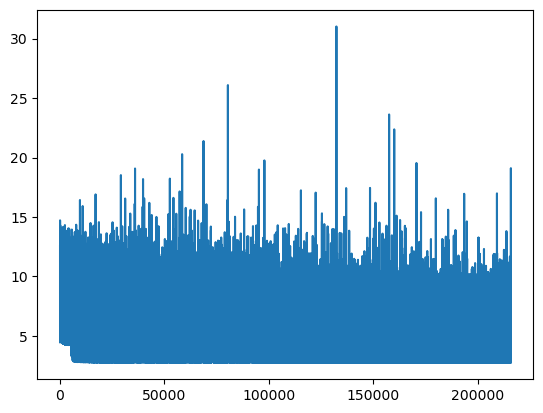

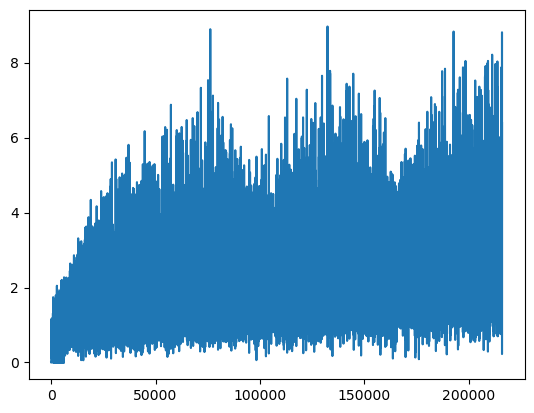

In [25]:
import matplotlib.pyplot as plt

plt.plot(loss_arr)
plt.show()
plt.plot(std_arr)
plt.show()

## Beam Search

In [8]:
import numpy as np
import torch


class Beamsearch(object):
    """Class for managing internals of beamsearch procedure.

    References:
        General: https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/beam.py
        For TSP: https://github.com/alexnowakvila/QAP_pt/blob/master/src/tsp/beam_search.py
    """

    def __init__(self, beam_size, batch_size, num_nodes,
                 dtypeFloat=torch.FloatTensor, dtypeLong=torch.LongTensor, 
                 probs_type='raw', random_start=False):
        """
        Args:
            beam_size: Beam size
            batch_size: Batch size
            num_nodes: Number of nodes in TSP tours
            dtypeFloat: Float data type (for GPU/CPU compatibility)
            dtypeLong: Long data type (for GPU/CPU compatibility)
            probs_type: Type of probability values being handled by beamsearch (either 'raw'/'logits'/'argmax'(TODO))
            random_start: Flag for using fixed (at node 0) vs. random starting points for beamsearch
        """
        # Beamsearch parameters
        self.batch_size = batch_size
        self.beam_size = beam_size
        self.num_nodes = num_nodes
        self.probs_type = probs_type
        # Set data types
        self.dtypeFloat = dtypeFloat
        self.dtypeLong = dtypeLong
        # Set beamsearch starting nodes
        self.start_nodes = torch.zeros(batch_size, beam_size).type(self.dtypeLong)
        if random_start == True:
            # Random starting nodes
            self.start_nodes = torch.randint(0, num_nodes, (batch_size, beam_size)).type(self.dtypeLong)
        # Mask for constructing valid hypothesis
        self.mask = torch.ones(batch_size, beam_size, num_nodes).type(self.dtypeFloat)
        self.update_mask(self.start_nodes)  # Mask the starting node of the beam search
        # Score for each translation on the beam
        self.scores = torch.zeros(batch_size, beam_size).type(self.dtypeFloat)
        self.all_scores = []
        # Backpointers at each time-step
        self.prev_Ks = []
        # Outputs at each time-step
        self.next_nodes = [self.start_nodes]

    def get_current_state(self):
        """Get the output of the beam at the current timestep.
        """
        current_state = (self.next_nodes[-1].unsqueeze(2)
                         .expand(self.batch_size, self.beam_size, self.num_nodes))
        return current_state

    def get_current_origin(self):
        """Get the backpointers for the current timestep.
        """
        return self.prev_Ks[-1]

    def advance(self, trans_probs):
        """Advances the beam based on transition probabilities.

        Args:
            trans_probs: Probabilities of advancing from the previous step (batch_size, beam_size, num_nodes)
        """
        # Compound the previous scores (summing logits == multiplying probabilities)
        if len(self.prev_Ks) > 0:
            if self.probs_type == 'raw':
                beam_lk = trans_probs * self.scores.unsqueeze(2).expand_as(trans_probs)
            elif self.probs_type == 'logits':
                beam_lk = trans_probs + self.scores.unsqueeze(2).expand_as(trans_probs)
        else:
            beam_lk = trans_probs
            # Only use the starting nodes from the beam
            if self.probs_type == 'raw':
                beam_lk[:, 1:] = torch.zeros(beam_lk[:, 1:].size()).type(self.dtypeFloat)
            elif self.probs_type == 'logits':
                beam_lk[:, 1:] = -1e20 * torch.ones(beam_lk[:, 1:].size()).type(self.dtypeFloat)
        # Multiply by mask
        beam_lk = beam_lk * self.mask
        beam_lk = beam_lk.view(self.batch_size, -1)  # (batch_size, beam_size * num_nodes)
        # Get top k scores and indexes (k = beam_size)
        bestScores, bestScoresId = beam_lk.topk(self.beam_size, 1, True, True)
        # Update scores
        self.scores = bestScores
        # Update backpointers
        prev_k = bestScoresId // self.num_nodes
        self.prev_Ks.append(prev_k)
        # Update outputs
        new_nodes = bestScoresId - prev_k * self.num_nodes
        self.next_nodes.append(new_nodes)
        # Re-index mask
        perm_mask = prev_k.unsqueeze(2).expand_as(self.mask)  # (batch_size, beam_size, num_nodes)
        self.mask = self.mask.gather(1, perm_mask)
        # Mask newly added nodes
        self.update_mask(new_nodes)

    def update_mask(self, new_nodes):
        """Sets new_nodes to zero in mask.
        """
        arr = (torch.arange(0, self.num_nodes).unsqueeze(0).unsqueeze(1)
               .expand_as(self.mask).type(self.dtypeLong))
        new_nodes = new_nodes.unsqueeze(2).expand_as(self.mask)
        update_mask = 1 - torch.eq(arr, new_nodes).type(self.dtypeFloat)
        self.mask = self.mask * update_mask
        if self.probs_type == 'logits':
            # Convert 0s in mask to inf
            self.mask[self.mask == 0] = 1e20

    def sort_best(self):
        """Sort the beam.
        """
        return torch.sort(self.scores, 0, True)

    def get_best(self):
        """Get the score and index of the best hypothesis in the beam.
        """
        scores, ids = self.sort_best()
        return scores[1], ids[1]

    def get_hypothesis(self, k):
        """Walk back to construct the full hypothesis.

        Args:
            k: Position in the beam to construct (usually 0s for most probable hypothesis)
        """
        assert self.num_nodes == len(self.prev_Ks) + 1

        hyp = -1 * torch.ones(self.batch_size, self.num_nodes).type(self.dtypeLong)
        for j in range(len(self.prev_Ks) - 1, -2, -1):
            hyp[:, j + 1] = self.next_nodes[j + 1].gather(1, k).view(1, self.batch_size)
            k = self.prev_Ks[j].gather(1, k)
        return hyp


In [9]:
import torch.nn.functional as F

def beamsearch_tour_nodes(y_pred_edges, beam_size, num_nodes):
    y = (F.softmax(y_pred_edges, dim=-1) + F.softmax(y_pred_edges, dim=-2)) / 2
    # Perform beamsearch
    beamsearch = Beamsearch(beam_size, 1, num_nodes)
    trans_probs = y.gather(1, beamsearch.get_current_state())
    for step in range(num_nodes - 1):
        beamsearch.advance(trans_probs)
        trans_probs = y.gather(1, beamsearch.get_current_state())
    # Find TSP tour with highest probability among beam_size candidates
    ends = torch.zeros(1, 1, dtype=torch.long)
    return beamsearch.get_hypothesis(ends)

In [11]:
import time
import pandas as pd

dataset = TspDataset(split = None)
instances = [path.stem for path in dataset.instances]
time_taken_arr = []
path_arr = []
tour_len_arr = []
num_dest_arr = []
for batch in tqdm(dataset):
    graph = batch
    with torch.no_grad():
        start = time.time_ns()
        
        out = model(graph)
        out = out.unsqueeze(0)
        path = beamsearch_tour_nodes(out, 5, out.shape[-1])[0]

        time_taken = time.time_ns() - start
    distance_matrix = graph.edge_attr

    tour_len = 0
    for y_idx in range(path.shape[0] - 1):
        i = path[y_idx]
        j = path[y_idx + 1]
        tour_len += distance_matrix[i, j]
    tour_len += distance_matrix[j, 0]  # Add final connection to tour/cycle

    time_taken_arr.append(time_taken)
    path_arr.append(str(path.tolist()))
    tour_len_arr.append(tour_len.item() * 1_000)
    num_dest_arr.append(path.shape[0])

df = pd.DataFrame({
    "instances": instances,
    "sequence": path_arr,
    "distances (m)": tour_len_arr,
    "time (ns)": time_taken_arr,
    "num_dests": num_dest_arr
})
df.to_csv("gnn_v1_beam_5_results.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████| 1271/1271 [00:08<00:00, 141.60it/s]
